In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# работа со звуковыми файлами и данными
import essentia
import librosa
from librosa import display as lbd

from IPython.core.display import Image, display

# Разработка алгоритма распознавания голосовых команд

## 1. Определения и постановка задачи
#### **Голосовая команда** - слово или слитно произнесённое короткое предложение, предполагающее выполнение конкретных действий.

#### Распознавание голосовых команд - принятие решения:
#### ` - либо о принадлежности фрагмента звучания к одному из известных классов,`
#### ` - либо о несоответствии ни одному из классов.`

  
#### **Задача**  - разработка алгоритма распознавания кодовых фраз, требующего минимальных вычислительных ресурсов и объёмов хранения.
  
#### Большинство современных методов решения этой задачи сводятся к преобразованию фрагментов звучания в изображения
#### и последующей классификации этих изображений предварительно обученной нейронной сетью.

#### Нейронные сети, используемые для классификации изображений требуют больших объёмов памяти и большого объёма вычислений.
#### Поэтому разрабатываемый алгоритм должен быть построен на более "легковесных" решениях.

## 2. Представления речевого сигнала в задачах машинного обучения

In [2]:
sample_path = '../data/commands/!select/bed/0a7c2a8d_nohash_0.aif'

#### Речевой сигнал - временной ряд, квазистационарный случайный процесс.
#### Интервал стационарности - 20-30 мс.

In [3]:
time_series, Fs = librosa.load(sample_path)

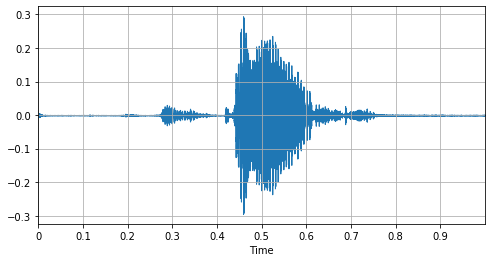

In [4]:
fig, ax = plt.subplots(figsize=(8,4))
lbd.waveplot(time_series, sr=Fs, ax=ax);
ax.grid(True)

#### **Форма сигнала - ненадёжный признак.**
#### В задачах классификации речевых сигналов используются различные представления спектра и их производные.
#### Основная цель - уйти от описания формы сигнала к описанию параметров речевого аппарата.

In [5]:
amp_spectrum = librosa.amplitude_to_db(np.abs(librosa.stft(time_series, n_fft=512, hop_length=256)), ref=np.max)

#### Short time analysis:
#### 1) разбиение временного ряда на перекрывающиеся фрагменты одинаковой длительности,
#### 2) вычисление параметров для каждого фрагмента.

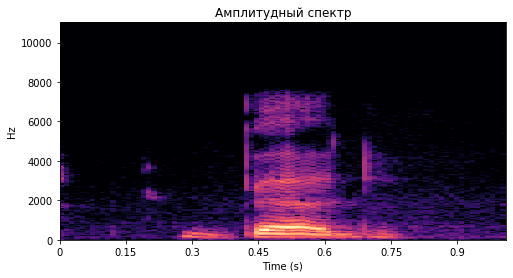

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
lbd.specshow(amp_spectrum, sr=Fs, ax=ax, hop_length=256, x_axis='s', y_axis='linear');
ax.set_title('Амплитудный спектр');

In [7]:
mfcc = librosa.feature.mfcc(time_series, sr=Fs, n_mfcc=64, lifter=1)

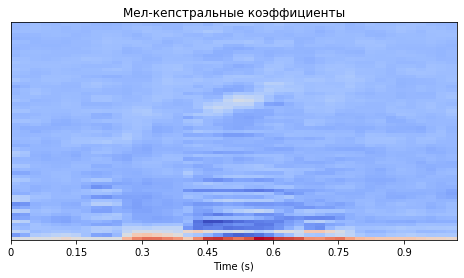

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
lbd.specshow(mfcc[1:], sr=Fs, hop_length=512, ax=ax, x_axis='s');
ax.set_title('Мел-кепстральные коэффициенты');

## 3. Идея решения задачи распознавания голосовых команд

#### **Предлагается построить решение на использовании алгоритма KNN.**
#### В памяти устройства хранятся образцы представлений голосовых команд.
#### Фрагмент звучания, поступающий с микрофона, преобразуется в нужное представление.
#### Полученное представление сравнивается с хранящимися образцами, по K ближайшим образцам
#### принимается решение о принадлежности к тому или иному классу.
#### Если дистанция до ближайших "соседей" слишком велика, звучание классиифицируется как неопознанное.
 <br></br> 
#### **Задача проекта:**
#### 1) выбрать способ представления (описания) фрагментов звучания,
#### 2) выбрать меру близости для сравнения представлений звуковых сигналов. 

## 4. Близость временных рядов разной длительности. Dynamic time warping

#### DTW позволяет обнаружить сходство форм двух временных рядов
![dtw vs euclidean](dtw_vs_euclidean_small.jpeg)

#### Алгоритм основан на вычислении "матрицы стоимости", каждый элемент [i, j] которой
#### содержит значение меры близости между i-тым элементом одного временного ряда
#### и j-тым элементом другого временного ряда.

![dtw algo 02](dtw_algo_02.jpg)

#### Далее в матрице стоимости находится "путь", обеспечивающий минимальную "стоимость",
#### т.е. минимальную суммарную меру близости между элементами временных рядов.

#### Для оптимизации времени поиска на форму пути могут накладываться ограничения:

![dtw algo 03](dtw_algo_03.jpg)

#### **Важны два момента:**
#### 1) временные ряды могут представлять собой последовательность элементов любой размерности,
#### 2) для элементов временых рядов должна быть определена (выбрана) мера близости.

#### Длина DTW path сама по себе может быть мерой близости между элементами многмерных временных рядов.
<br></br>

#### **Применение DTW к двумерному временному ряду.**
#### Звуковой сигнал представляется в виде двумерной матрицы с использованием short time analysis.
#### Каждый столбец матрицы соответствует набору параметров, описывающих один сегмент сигнала
#### (например, амплитуды спектральных компонент).
#### Каждая строка описывает зависимость отдельного параметра описания
#### (например, амплитуда отдельной компоненты спектра) от времени (номера сегмента)
#### Такие представления будут иметь **одинаковое** число **строк** и *разное* число *столбцов*.
<br></br>
#### В проекте предлагается сравнить два способа вычисления дистанции между представлениями звуковых сигналов,
#### т.е. матриц с разным количеством стобцов и одинаковым количеством строк:
#### 1) вычислять меру близости между стобцами,
#### 2) вычислять меру близости между строками и брать среднее значение.

![DTW 2D small](DTW_2D_small.jpg)